In [ ]:
import numpy as np
import pandas as pd
from data_process import *
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from metadata import *
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import AnchoredText


In [ ]:
match_level_df = pd.DataFrame(season_summary_df[['season', 'id', 'home_team', 'away_team', 'winner', 'description']])
match_level_df['stage'] = match_level_df['description'].apply(lambda x: x.split(',')[0].title())

In [ ]:
alt = 1
def stage_score(row, team_code):
    global alt
    alt += 1
    if 'Eliminator' in row['stage'] or '3Rd Place Play-Off' in row['stage'] or 'Elimination Final' in row['stage']:
        return 7*((-1)**alt)
    if 'Match' == row['stage'].split(' ')[1]:
        return 6*((-1)**alt)
    if 'Qualifier 2' in row['stage'] or '1St Qualifying Final' in row['stage']:
        return 9*((-1)**alt)
    if 'Qualifier 1' in row['stage'] or '2Nd Qualifying Final' in row['stage']:
        return 8*((-1)**alt)
    if 'Semi-Final' in row['stage']:
        return 7.5*((-1)**alt)
    if 'Final' in row['stage']:
        if row['winner'] != team_code:
            return 9.5*((-1)**alt)
        return 10*((-1)**alt)
    return 4*((-1)**alt)

    

In [ ]:
def team_journey_plot(team_code):
    team_df = pd.DataFrame(match_level_df[(match_level_df['home_team'] == team_code) | (match_level_df['away_team'] == team_code)])
    team_df = team_df.sort_values('id', ascending=False).drop_duplicates(['season'])
    team_df['stage_score'] = team_df.apply(lambda row: stage_score(row, team_code), axis=1)
    team_df['stage'] = team_df[['stage', 'stage_score']].apply(lambda x: x['stage'] if np.abs(x['stage_score']) !=10 else 'Winner', axis=1)
    names = team_df['stage']
    dates = team_df['season'].to_list()
    dates = [datetime.strptime(str(x), '%Y') for x in dates]
    levels = team_df['stage_score'].to_list()

    plt.rcParams['figure.dpi'] = 200
    fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True,facecolor='#ffffff')
    ax.set_title("{} Journey".format(team_code), fontsize=14)
    ax.vlines(dates, 0, levels, color='#fdb913')  # The vertical stems.
    ax.plot(dates, np.zeros_like(dates), "-o",
            color='#fdb913', markerfacecolor="g") 
    for d, l, r in zip(dates, levels, names):
        fontsize = 10    
        color = 'black'
        if r == 'Winner':
            fontsize=14
            color = '#2c8a83'
        ax.annotate(r, xy=(d, l),
                        xytext=(-4, np.sign(l)*4), textcoords="offset points",
                    horizontalalignment="center",
                    fontsize = fontsize,
                    color=color,
                    verticalalignment="bottom" if l > 0 else "top")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right"]].set_visible(False)

    ax.margins(y=0.1)
    plt.show()

team_journey_plot('RCB')


In [ ]:
def percent_win_to_opponent(team_code):
    """
    This function will plot a bar graph for % win to other teams
    """
    team_df = season_summary_df[['home_team', 'away_team', 'winner']]
    team_df = team_df[(team_df['home_team'] == team_code) | (team_df['away_team'] == team_code)]
    team_df['against'] = team_df.apply(lambda x: x['home_team'] if x['away_team'] == team_code else x['away_team'], axis=1)
    team_df['win'] = team_df.apply(lambda x: 1 if x['winner'] == team_code else 0, axis=1)
    team_df['lose'] = team_df.apply(lambda x: 1 if x['winner'] != team_code and x['winner'] in team_name_dict else 0, axis=1)
    team_df['no result'] = team_df.apply(lambda x: 1 if x['win']  ==0 and x['lose'] == 0 else 0, axis=1)
    team_df['total'] =  1
    team_df = team_df.groupby(['against'])[['win', 'lose', 'no result', 'total']].sum().reset_index()
    
    team_df['win_percent'] = team_df.apply(lambda x: x['win']/x['total']*100, axis=1)
    team_df['lose_percent'] = team_df.apply(lambda x: x['lose']/x['total']*100, axis=1)
    team_df['no result'] = team_df.apply(lambda x: x['no result']/x['total']*100, axis=1)
    
    team_df = team_df.sort_values('win_percent', ascending=False)
    #plot win_percent, lose_percent, no result to other teams
    team_df.plot(kind='bar', x='against', y=['win_percent', 'lose_percent', 'no result'], figsize=(10,4))
    
percent_win_to_opponent('RCB')
    

In [ ]:
def percent_win_by_season(team_code):
    """
    This function will plot a bar graph for % win by season
    """
    team_df = season_summary_df[['season', 'home_team', 'away_team', 'winner']]
    team_df = team_df[(team_df['home_team'] == team_code) | (team_df['away_team'] == team_code)]
    team_df['win'] = team_df.apply(lambda x: 1 if x['winner'] == team_code else 0, axis=1)
    team_df['total'] = 1
    team_df = team_df.groupby(['season'])[['win', 'total']].sum().reset_index()
    team_df['win_percent'] = team_df.apply(lambda x: x['win']/x['total']*100, axis=1)
    
    team_df.plot(kind='bar', x='season', y='win_percent', figsize=(10,4))

percent_win_by_season('RCB')   
    

In [ ]:
def percent_win_by_venue(team_code):
    """
    This function will plot a bar graph for % win by venue
    """
    team_df = season_summary_df[['venue_name', 'home_team', 'away_team', 'winner']]
    team_df = team_df[(team_df['home_team'] == team_code) | (team_df['away_team'] == team_code)]
    team_df['win'] = team_df.apply(lambda x: 1 if x['winner'] == team_code else 0, axis=1)
    team_df['total'] = 1
    team_df = team_df.groupby(['venue_name'])[['win', 'total']].sum().reset_index()
    team_df['win_percent'] = team_df.apply(lambda x: x['win']/x['total']*100, axis=1)
    
    team_df.plot(kind='bar', x='venue_name', y='win_percent', figsize=(10,4))

percent_win_by_venue('RCB')
    

In [ ]:
def percent_win_by_innings(team_code):
    """
    This function will plot graph on the basis bat first/bowl first
    """
    team_df = season_summary_df[['decision', 'winner']]
    team_df = team_df[(team_df['winner'] == team_code)]
    team_df = team_df.groupby(['decision'])[['winner']].count().reset_index()
    team_df_sum = team_df['winner'].sum()
    team_df['winner'] = team_df.apply(lambda x: x['winner']/team_df_sum*100, axis=1)
    team_df.plot(kind='bar', x='decision', y='winner', figsize=(10,4))

percent_win_by_innings('RCB')

In [ ]:
def top_scorer_all_time(team_code):
    """
    This function will plot top 10 run scorer for the team

    Args:
        team_code ([string]): [the players from team we want to see]
    """
    scorer_match_df = season_batting_card_df[['fullName', 'current_innings' , 'runs']]
    scorer_match_df = scorer_match_df[scorer_match_df['current_innings'] == team_code]
    scorer_match_df = scorer_match_df.groupby(['fullName'])[['runs']].sum().reset_index().sort_values('runs', ascending=False)
    scorer_match_df = scorer_match_df.head(10)
    scorer_match_df.plot(kind='bar', x='fullName', y='runs', figsize=(10,4))

top_scorer_all_time('RCB')
    

In [ ]:
def top_scorer_against(team_code):
    """
    This function will plot top batter scorer against each team
    """
    player_df = season_batting_card_df[['fullName', 'current_innings', 'runs', 'home_team', 'away_team']]
    player_df = player_df[player_df['current_innings'] == team_code]
    player_df = player_df[(player_df['current_innings'] == team_code) | (player_df['current_innings'] == team_code)]
    player_df['against'] = player_df.apply(lambda x: x['home_team'] if x['away_team'] == team_code else x['away_team'], axis=1)
    player_df = player_df.groupby(['against', 'fullName'])[['runs']].sum().reset_index().sort_values('runs', ascending=False)

    plt.rcParams['figure.dpi'] = 600
    background_color = '#ffffff'
    fig = plt.figure(figsize=(10, 14), facecolor='#ffffff')

    gs = fig.add_gridspec(6, 2)
    gs.update(wspace=0.3, hspace=0.4)

    run_no = 0
    for row in range(0, 6):
        for col in range(0, 2):
            locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
            locals()["ax"+str(run_no)].set_facecolor(background_color)
            for s in ["top","right"]:
                locals()["ax"+str(run_no)].spines[s].set_visible(False)
            run_no += 1
    run_no = 0
    for opp in player_df['against'].unique():
        locals()["ax"+str(run_no)].set_facecolor(team_color[opp])
        player_df_opp = player_df[player_df['against'] == opp].head(7)
        divider = make_axes_locatable(locals()["ax"+str(run_no)])
        cax = divider.append_axes("top", size="20%", pad=0)
        cax.get_xaxis().set_visible(False)
        cax.get_yaxis().set_visible(False)
        cax.set_facecolor(team_color[opp])
        at = AnchoredText(team_name_dict[opp], loc=10, 
                        prop=dict(backgroundcolor=team_color[opp],
                                    size=12, color='white', weight='bold'))
        cax.add_artist(at)
        sns.barplot(ax=locals()["ax"+str(run_no)], y=player_df_opp['fullName'], x=player_df_opp['runs'], zorder=2, linewidth=0, orient='h', saturation=1, alpha=1, color=team_color[team_code])
        locals()["ax"+str(run_no)].set_ylabel('')
        locals()["ax"+str(run_no)].set_yticklabels(locals()["ax"+str(run_no)].get_yticklabels(), fontsize=12, fontweight='bold')
        locals()["ax"+str(run_no)].set_xlabel('')
        locals()["ax"+str(run_no)].tick_params(left=False)
        x_ticks = np.arange(100, 900, 100)
        locals()["ax"+str(run_no)].set_xticks(x_ticks)
        locals()["ax"+str(run_no)].set_xticklabels(x_ticks, fontsize=10, fontweight='bold')        
        run_no += 1

    locals()["ax"+str(run_no)].axis('off')
    for run_no in range (0,11):
        for p in locals()["ax"+str(run_no)].patches:
            value = int(p.get_width())
            x = p.get_x() + p.get_width() + 10.01
            y = p.get_y() + p.get_height() / 2 
            locals()["ax"+str(run_no)].text(x, y, value, ha='left', va='center', fontsize=10, 
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', linewidth=0.1))

    fig.suptitle('Top run scorers (vs opponent)',fontsize = 14)
    gs.tight_layout(fig, rect=[0, 0, 1, 0.99])
    plt.show()
top_scorer_against('RCB')


In [ ]:
def scorer_per_season(team_code):
    player_df = season_batting_card_df[['season', 'fullName', 'current_innings', 'runs']]
    player_df = player_df[player_df['current_innings'] == team_code]
    player_df = player_df.groupby(['season', 'fullName'])[['runs']].sum().reset_index().sort_values('runs', ascending=False)
    plt.rcParams['figure.dpi'] = 600
    background_color = '#ffffff'
    fig = plt.figure(figsize=(10, 14), facecolor='#ffffff')
    #
    gs = fig.add_gridspec(6, 2)
    gs.update(wspace=0.3, hspace=0.4)

    run_no = 0
    for row in range(0, 6):
        for col in range(0, 2):
            locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
            locals()["ax"+str(run_no)].set_facecolor(background_color)
            for s in ["top"]:
                locals()["ax"+str(run_no)].spines[s].set_visible(False)
            run_no += 1

    run_no = 0
    for season in sorted(player_df['season'].unique()):
        locals()["ax"+str(run_no)].set_facecolor('#ffffff')
        player_run = player_df[player_df['season'] == season].head(7)
        divider = make_axes_locatable(locals()["ax"+str(run_no)])
        cax = divider.append_axes("top", size="20%", pad=0)
        cax.get_xaxis().set_visible(False)
        cax.get_yaxis().set_visible(False)
        cax.set_facecolor('#525453')
        at = AnchoredText(season, loc=10, 
                        prop=dict(backgroundcolor='#525453',
                                    size=11, color='white', weight='bold'))    
        
        cax.add_artist(at)
        
        sns.barplot(ax=locals()["ax"+str(run_no)], y=player_run['fullName'], x=player_run['runs'], zorder=2, linewidth=0, orient='h', saturation=1, alpha=1, color=team_color[team_code])
        locals()["ax"+str(run_no)].set_ylabel('')
        x_ticks_runs = np.arange(0, 800, 100)
        locals()["ax"+str(run_no)].set_xticks(x_ticks_runs)
        locals()["ax"+str(run_no)].set_xticklabels(x_ticks_runs, fontsize=10, fontweight='bold') 
        locals()["ax"+str(run_no)].tick_params(left=False, bottom=False)    
        locals()["ax"+str(run_no)].set_yticklabels(locals()["ax"+str(run_no)].get_yticklabels(), fontsize=12, fontweight='bold')
        locals()["ax"+str(run_no)].set_xlabel('')
        run_no += 1
        
    for run_no in range (0,12):
        for p in locals()["ax"+str(run_no)].patches:
    #        value = f'{p.get_width():.2f}'
            value = int(p.get_width())
            x = p.get_x() + p.get_width() + 8.01
            y = p.get_y() + p.get_height() / 2 
            locals()["ax"+str(run_no)].text(x, y, value, ha='left', va='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', linewidth=0.1))

    fig.suptitle('Top run scorers by season',fontsize = 14)
    gs.tight_layout(fig, rect=[0, 0, 1, 0.99])
    plt.show()
scorer_per_season('CSK')


In [ ]:
def all_time_partnership(team_code):
    """
    This function will plot top 15 best partnership combination for a team
    """
    partnership_df = season_details_df[['current_innings', 'batsman1_name', 'batsman2_name', 'runs']]
    partnership_df = partnership_df[partnership_df['current_innings'] == team_code]
    partnership_df['partner1_run'] = partnership_df.apply(lambda x: x['runs'] if x['batsman1_name'] < x['batsman2_name'] else 0, axis = 1)
    partnership_df['partner2_run'] = partnership_df.apply(lambda x: x['runs'] if x['batsman1_name'] > x['batsman2_name'] else 0, axis = 1)
    partnership_df['partner'] = partnership_df.apply(lambda x: '-'.join(sorted([x['batsman1_name'], x['batsman2_name']])), axis = 1)
    partnership_df = partnership_df.groupby(['partner'])[['runs', 'partner1_run', 'partner2_run']].sum().reset_index().sort_values('runs', ascending=False).head(20)

    plt.rcParams['figure.dpi'] = 600
    background_color = '#ffffff'
    fig = plt.figure(figsize=(14,8), facecolor='#ffffff')

    gs = fig.add_gridspec(1,1)
    gs.update(wspace=0.3, hspace=0.4)

    locals()["ax"+str(0)] = fig.add_subplot(gs[0, 0])
    locals()["ax"+str(0)].set_facecolor(background_color)
    for s in ['left', 'right', 'top', 'bottom']:
        locals()["ax"+str(0)].spines[s].set_visible(False)

    locals()["ax"+str(0)].barh(partnership_df['partner'], partnership_df['partner1_run'], label='batsman1_runs', color='#9e9a75')
    ax2 = locals()["ax"+str(0)].twinx()
    ax2.barh(partnership_df['partner'], partnership_df['partner2_run'], left=partnership_df['partner1_run'], label='batsman2_runs', color='#41533b')
    ax2.invert_yaxis()
    ytick_lbls = []
    for lbl in partnership_df['partner']:
        ytick_lbls.append(lbl.split('-')[1].strip())
        
    ax2.set_yticklabels(ytick_lbls, fontsize=12, fontweight='bold')
    locals()["ax"+str(0)].invert_yaxis()

    ytick_lbls = []
    for lbl in partnership_df['partner']:
        ytick_lbls.append(lbl.split('-')[0].strip())

    locals()["ax"+str(0)].set_yticklabels(ytick_lbls, fontsize=10, fontweight='bold')
    locals()["ax"+str(0)].set_xticklabels(locals()["ax"+str(0)].get_xticklabels(), fontsize=6, fontweight='bold')
    locals()["ax"+str(0)].grid(axis='y', linewidth=0.2,linestyle='dashed')

    locals()["ax"+str(0)].set_title('All-time Partnerships (runs scored)',fontsize=14, fontweight='bold')

    for s in ['left', 'right', 'top', 'bottom']:
        locals()["ax"+str(0)].spines[s].set_visible(False)
        ax2.spines[s].set_visible(False)

    locals()["ax"+str(0)].xaxis.set_visible(False) 
    locals()["ax"+str(0)].tick_params(left = False) 
    ax2.tick_params(right = False) 
    ax2.xaxis.set_visible(False) 

    for p in locals()["ax"+str(0)].patches:
        value = f'{p.get_width()}'        
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() / 2 
        locals()["ax"+str(0)].text(x, y, value, ha='left', va='center', fontsize=10, color='white',fontweight='bold',
                bbox=dict(facecolor='#9e9a75', edgecolor='#9e9a75',boxstyle='round', linewidth=0.1))

    for p in ax2.patches:
        value = f'{p.get_width()}'        
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() / 2 
        ax2.text(x, y, value, ha='left', va='center', fontsize=12, color='white',fontweight='bold',
                bbox=dict(facecolor='#41533b', edgecolor='#41533b', boxstyle='round', linewidth=0.1))

    for p, total in zip(ax2.patches, partnership_df['runs']):  
        x = p.get_x() + p.get_width() - 30
        y = p.get_y() + p.get_height() / 2 
        ax2.text(x, y, total, ha='left', va='center', fontsize=12, color='black',fontweight='bold',
                bbox=dict(facecolor=team_color[team_code], edgecolor='#41533b', boxstyle='round', linewidth=0.1)) 
        
    gs.tight_layout(fig, rect=[0, 0, 1, 0.99])
    plt.show()
all_time_partnership('SRH')


In [ ]:
def top_bolwers_by_wicket(team_code):
    bowler_df = season_bowling_card_df[['bowling_team', 'fullName','wickets']]
    bowler_df = bowler_df[bowler_df['bowling_team'] == team_code]
    bowler_df = bowler_df.groupby(['fullName'])['wickets'].sum().reset_index().sort_values('wickets', ascending=False).head(15)

    plt.rcParams['figure.dpi'] = 600
    background_color = '#ffffff'
    fig = plt.figure(figsize=(10, 14), facecolor='#ffffff')

    gs = fig.add_gridspec(1,1)
    gs.update(wspace=0.3, hspace=0.4)

    locals()["ax"+str(0)] = fig.add_subplot(gs[0, 0])
    locals()["ax"+str(0)].set_facecolor(background_color)
    for s in ['left', 'right', 'top']:
        locals()["ax"+str(0)].spines[s].set_visible(False)

    locals()["ax"+str(0)].barh(y = bowler_df['fullName'], width= bowler_df['wickets'], label='wickets', color='#9e9a75')
    locals()["ax"+str(0)].set_yticklabels(bowler_df['fullName'], fontsize=12, fontweight='bold')
    locals()["ax"+str(0)].tick_params(left=False)
    x_ticks = np.arange(10, 120, 20)
    #locals()["ax0"].set_xticks(x_tikcs)
    locals()["ax0"].set_xticklabels(x_ticks, fontsize=12, fontweight='bold')    
    locals()["ax0"].set_xlabel('Wickets',fontsize=12,fontweight='bold')

    locals()["ax"+str(0)].set_title('Top wicket taking bowlers (all-time)',fontsize=14, fontweight='bold')
    for s in ['left', 'right', 'top']:
        locals()["ax"+str(0)].spines[s].set_visible(False)

    locals()["ax"+str(0)].xaxis.set_visible(True) 
    locals()["ax"+str(0)].invert_yaxis()
    for p in locals()["ax"+str(0)].patches:
    #        value = f'{p.get_width():.2f}'
        value = f'{p.get_width()}'        
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() / 2 
        locals()["ax"+str(0)].text(x, y, value, ha='left', va='center', fontsize=14, color='White',fontweight='bold',
                bbox=dict(facecolor='#41533b', edgecolor=None, boxstyle='round', linewidth=0.1)
                                )


    gs.tight_layout(fig, rect=[0, 0, 1, 1])
    plt.show()
top_bolwers_by_wicket('SRH')

In [ ]:
def top_bowler_against(team_code):
    """
    plot 10 top bowler against each other
    """
    bowler_df  = season_bowling_card_df[['home_team', 'away_team', 'bowling_team', 'fullName', 'wickets']]
    bowler_df = bowler_df[bowler_df['bowling_team'] == team_code]
    bowler_df = bowler_df[(bowler_df['home_team'] == team_code) | (bowler_df['away_team'] == team_code)]
    bowler_df['against'] = bowler_df.apply(lambda x: x['home_team'] if x['away_team'] == team_code else x['away_team'], axis=1)
    bowler_df = bowler_df.groupby(['fullName', 'against'])['wickets'].sum().reset_index().sort_values('wickets', ascending=False)

    x_ticks = None
    #Plot the data
    plt.rcParams['figure.dpi'] = 600
    background_color = '#ffffff'
    fig = plt.figure(figsize=(10, 14), facecolor='#ffffff')
    #
    gs = fig.add_gridspec(6, 2)
    gs.update(wspace=0.3, hspace=0.4)

    run_no = 0
    for row in range(0, 6):
        for col in range(0, 2):
            locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
            locals()["ax"+str(run_no)].set_facecolor(background_color)
            for s in ["top","right"]:
                locals()["ax"+str(run_no)].spines[s].set_visible(False)
            run_no += 1

    run_no = 0
    for opp in bowler_df['against'].unique(): 
        locals()["ax"+str(run_no)].set_facecolor(team_color[opp])     
        wickets = bowler_df.loc[bowler_df['against'] == opp].head(6)
        if opp == 'Kochi':
            wickets = bowler_df.loc[bowler_df['against'] == opp].head(4)
        
        divider = make_axes_locatable(locals()["ax"+str(run_no)])
        cax = divider.append_axes("top", size="20%", pad=0)
        cax.get_xaxis().set_visible(False)
        cax.get_yaxis().set_visible(False)
        cax.set_facecolor(team_color[opp])
        at = AnchoredText(team_name_dict[opp], loc=10, 
                        prop=dict(backgroundcolor=team_color[opp],
                                    size=12, color='white', weight='bold'))    
        
        cax.add_artist(at)
        
        sns.barplot(ax=locals()["ax"+str(run_no)], y=wickets['fullName'], x=wickets['wickets'], zorder=2, linewidth=0, orient='h', saturation=1, alpha=1, color=team_color[team_code])
        locals()["ax"+str(run_no)].set_ylabel('')
        locals()["ax"+str(run_no)].set_yticklabels(locals()["ax"+str(run_no)].get_yticklabels(), fontsize=12, fontweight='bold')
        locals()["ax"+str(run_no)].set_xlabel('')
        locals()["ax"+str(run_no)].tick_params(left=False)
        x_ticks = np.arange(5, 35, 5)
        locals()["ax"+str(run_no)].set_xticks(x_ticks)
        locals()["ax"+str(run_no)].set_xticklabels(x_ticks, fontsize=12, fontweight='bold')    
        run_no += 1
    locals()["ax"+str(run_no)].axis('off')

    for run_no in range (0,9):
        for p in locals()["ax"+str(run_no)].patches:
    #        value = f'{p.get_width():.2f}'
            value = int(p.get_width())
            x = p.get_x() + p.get_width() + .5
            y = p.get_y() + p.get_height() / 2 
            locals()["ax"+str(run_no)].text(x, y, value, ha='left', va='center', fontsize=12, 
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', linewidth=0.1))

    fig.suptitle('Top wicket takers (vs opponent)',fontsize = 14)
    gs.tight_layout(fig, rect=[0, 0, 1, 0.99])
    plt.show()
top_bowler_against('RCB')
    

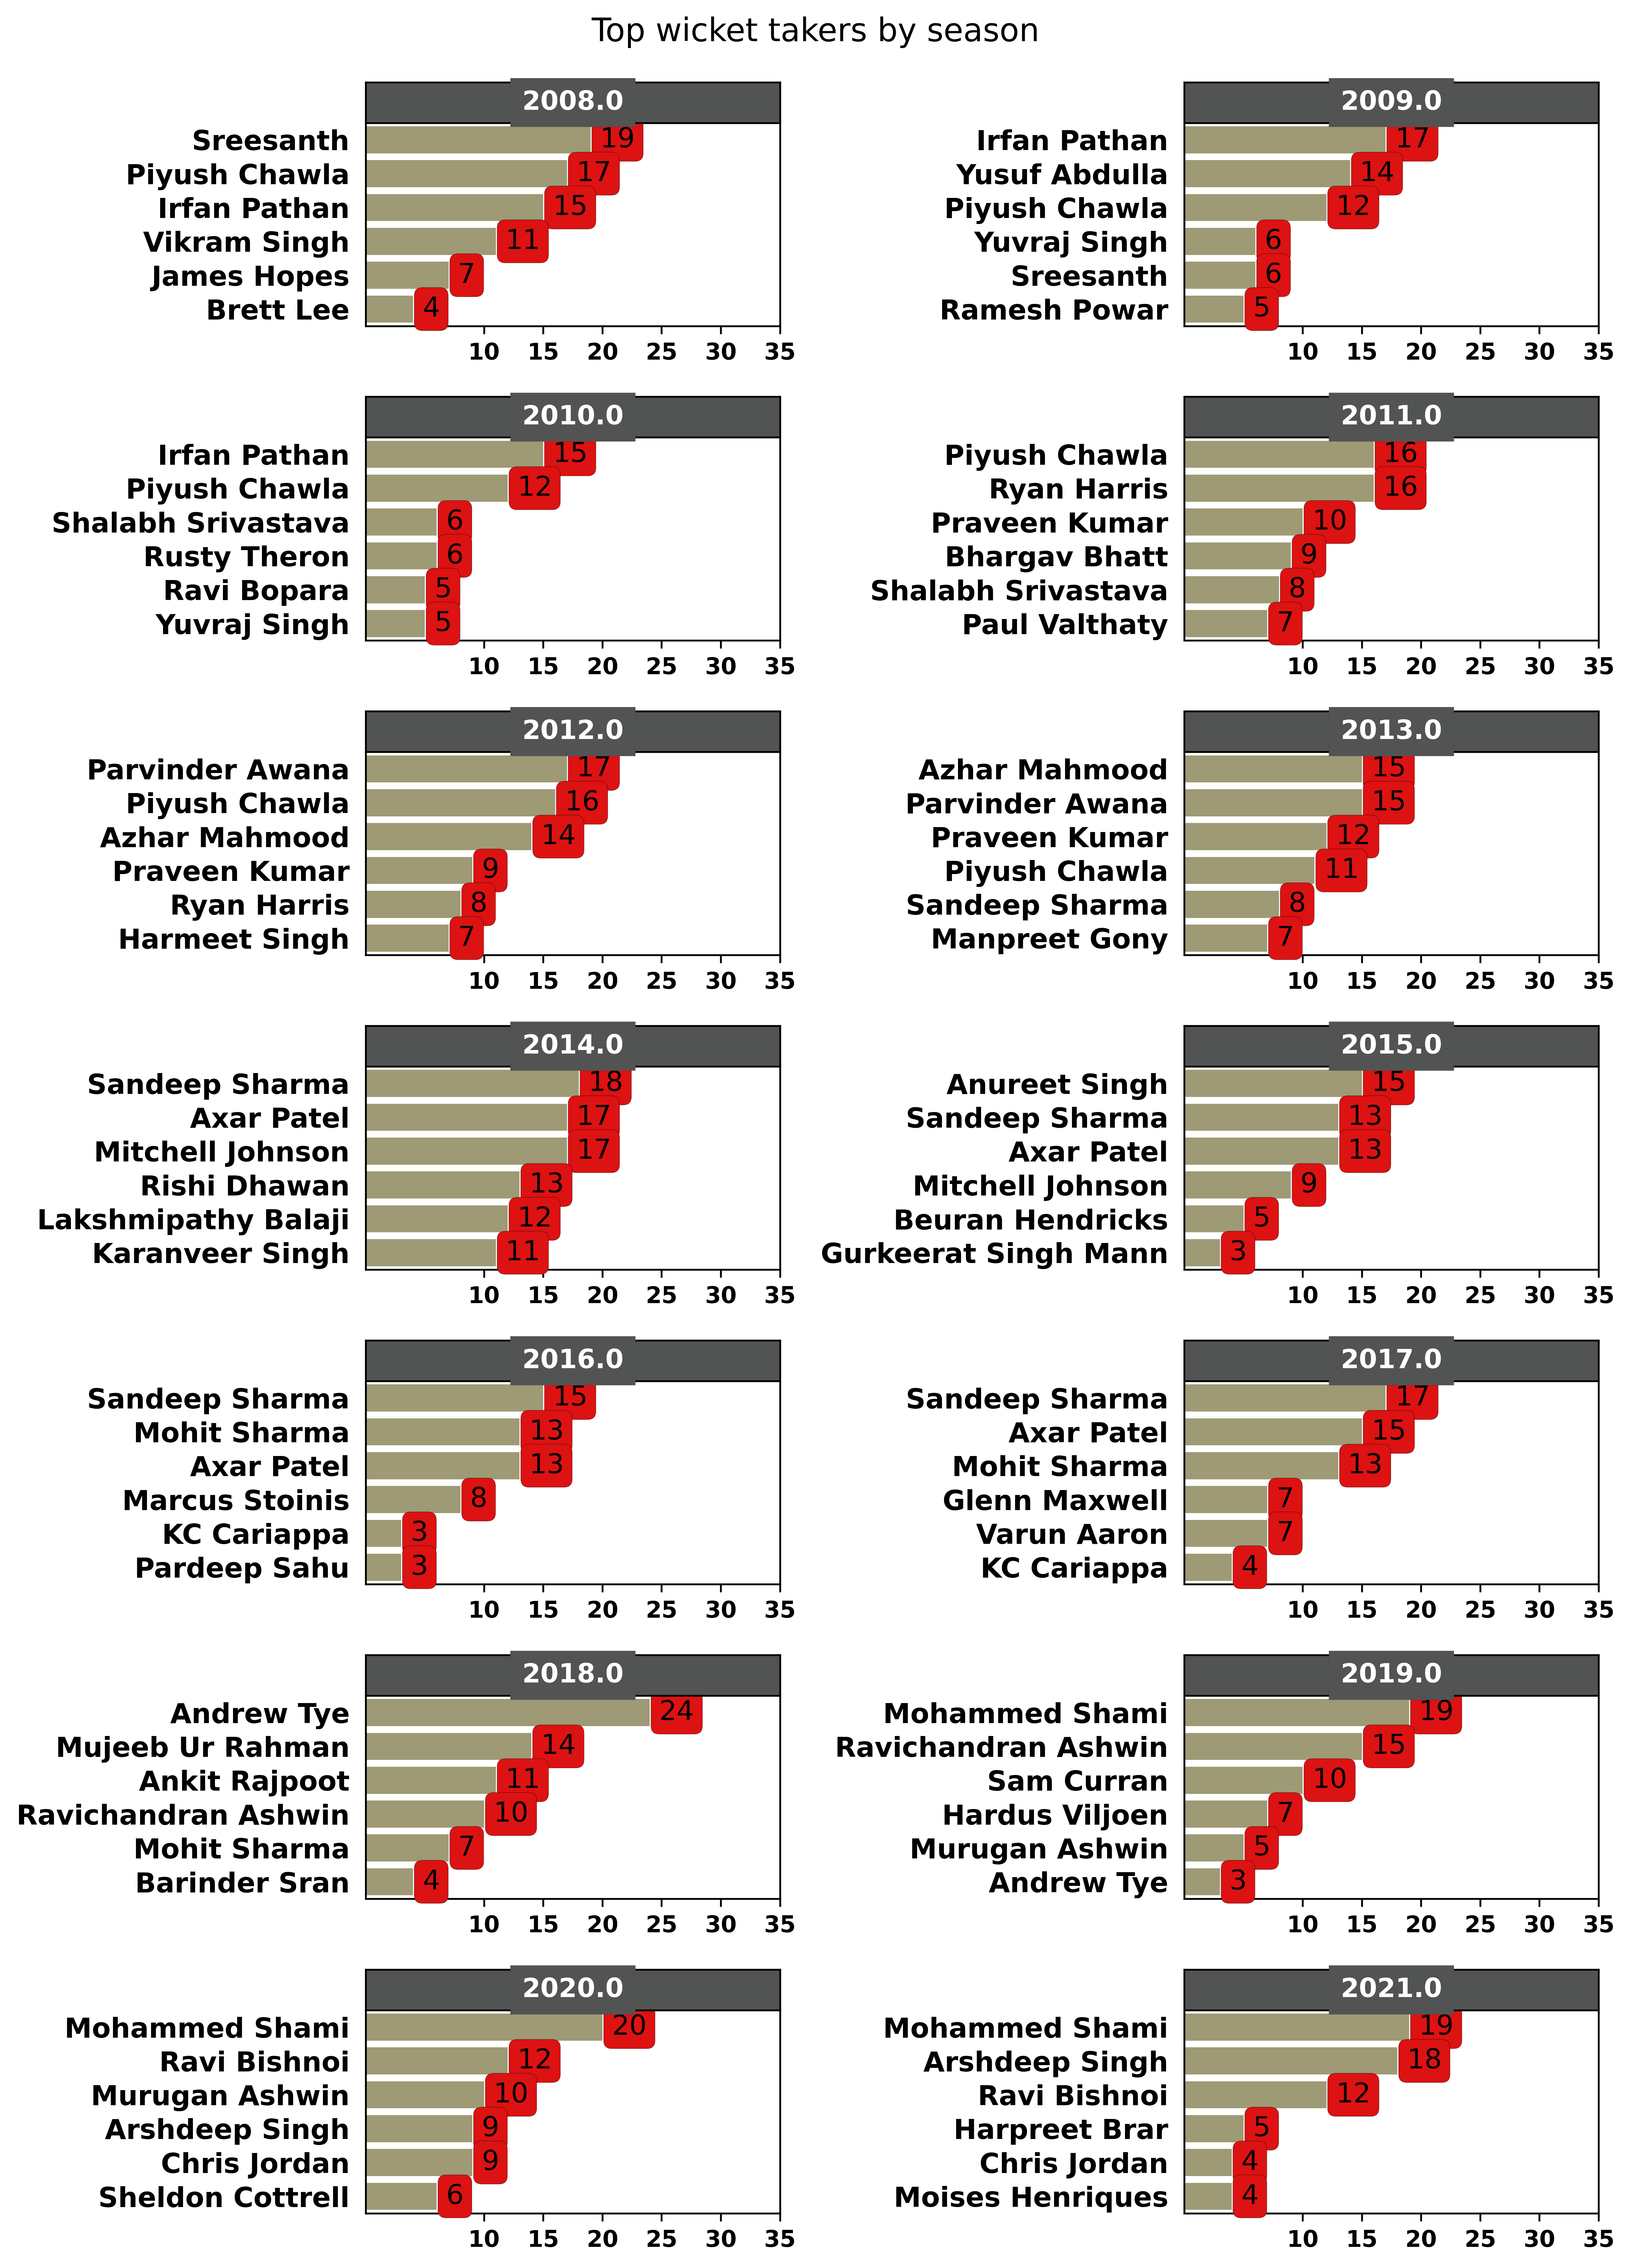

In [30]:
team_code = 'PBKS'


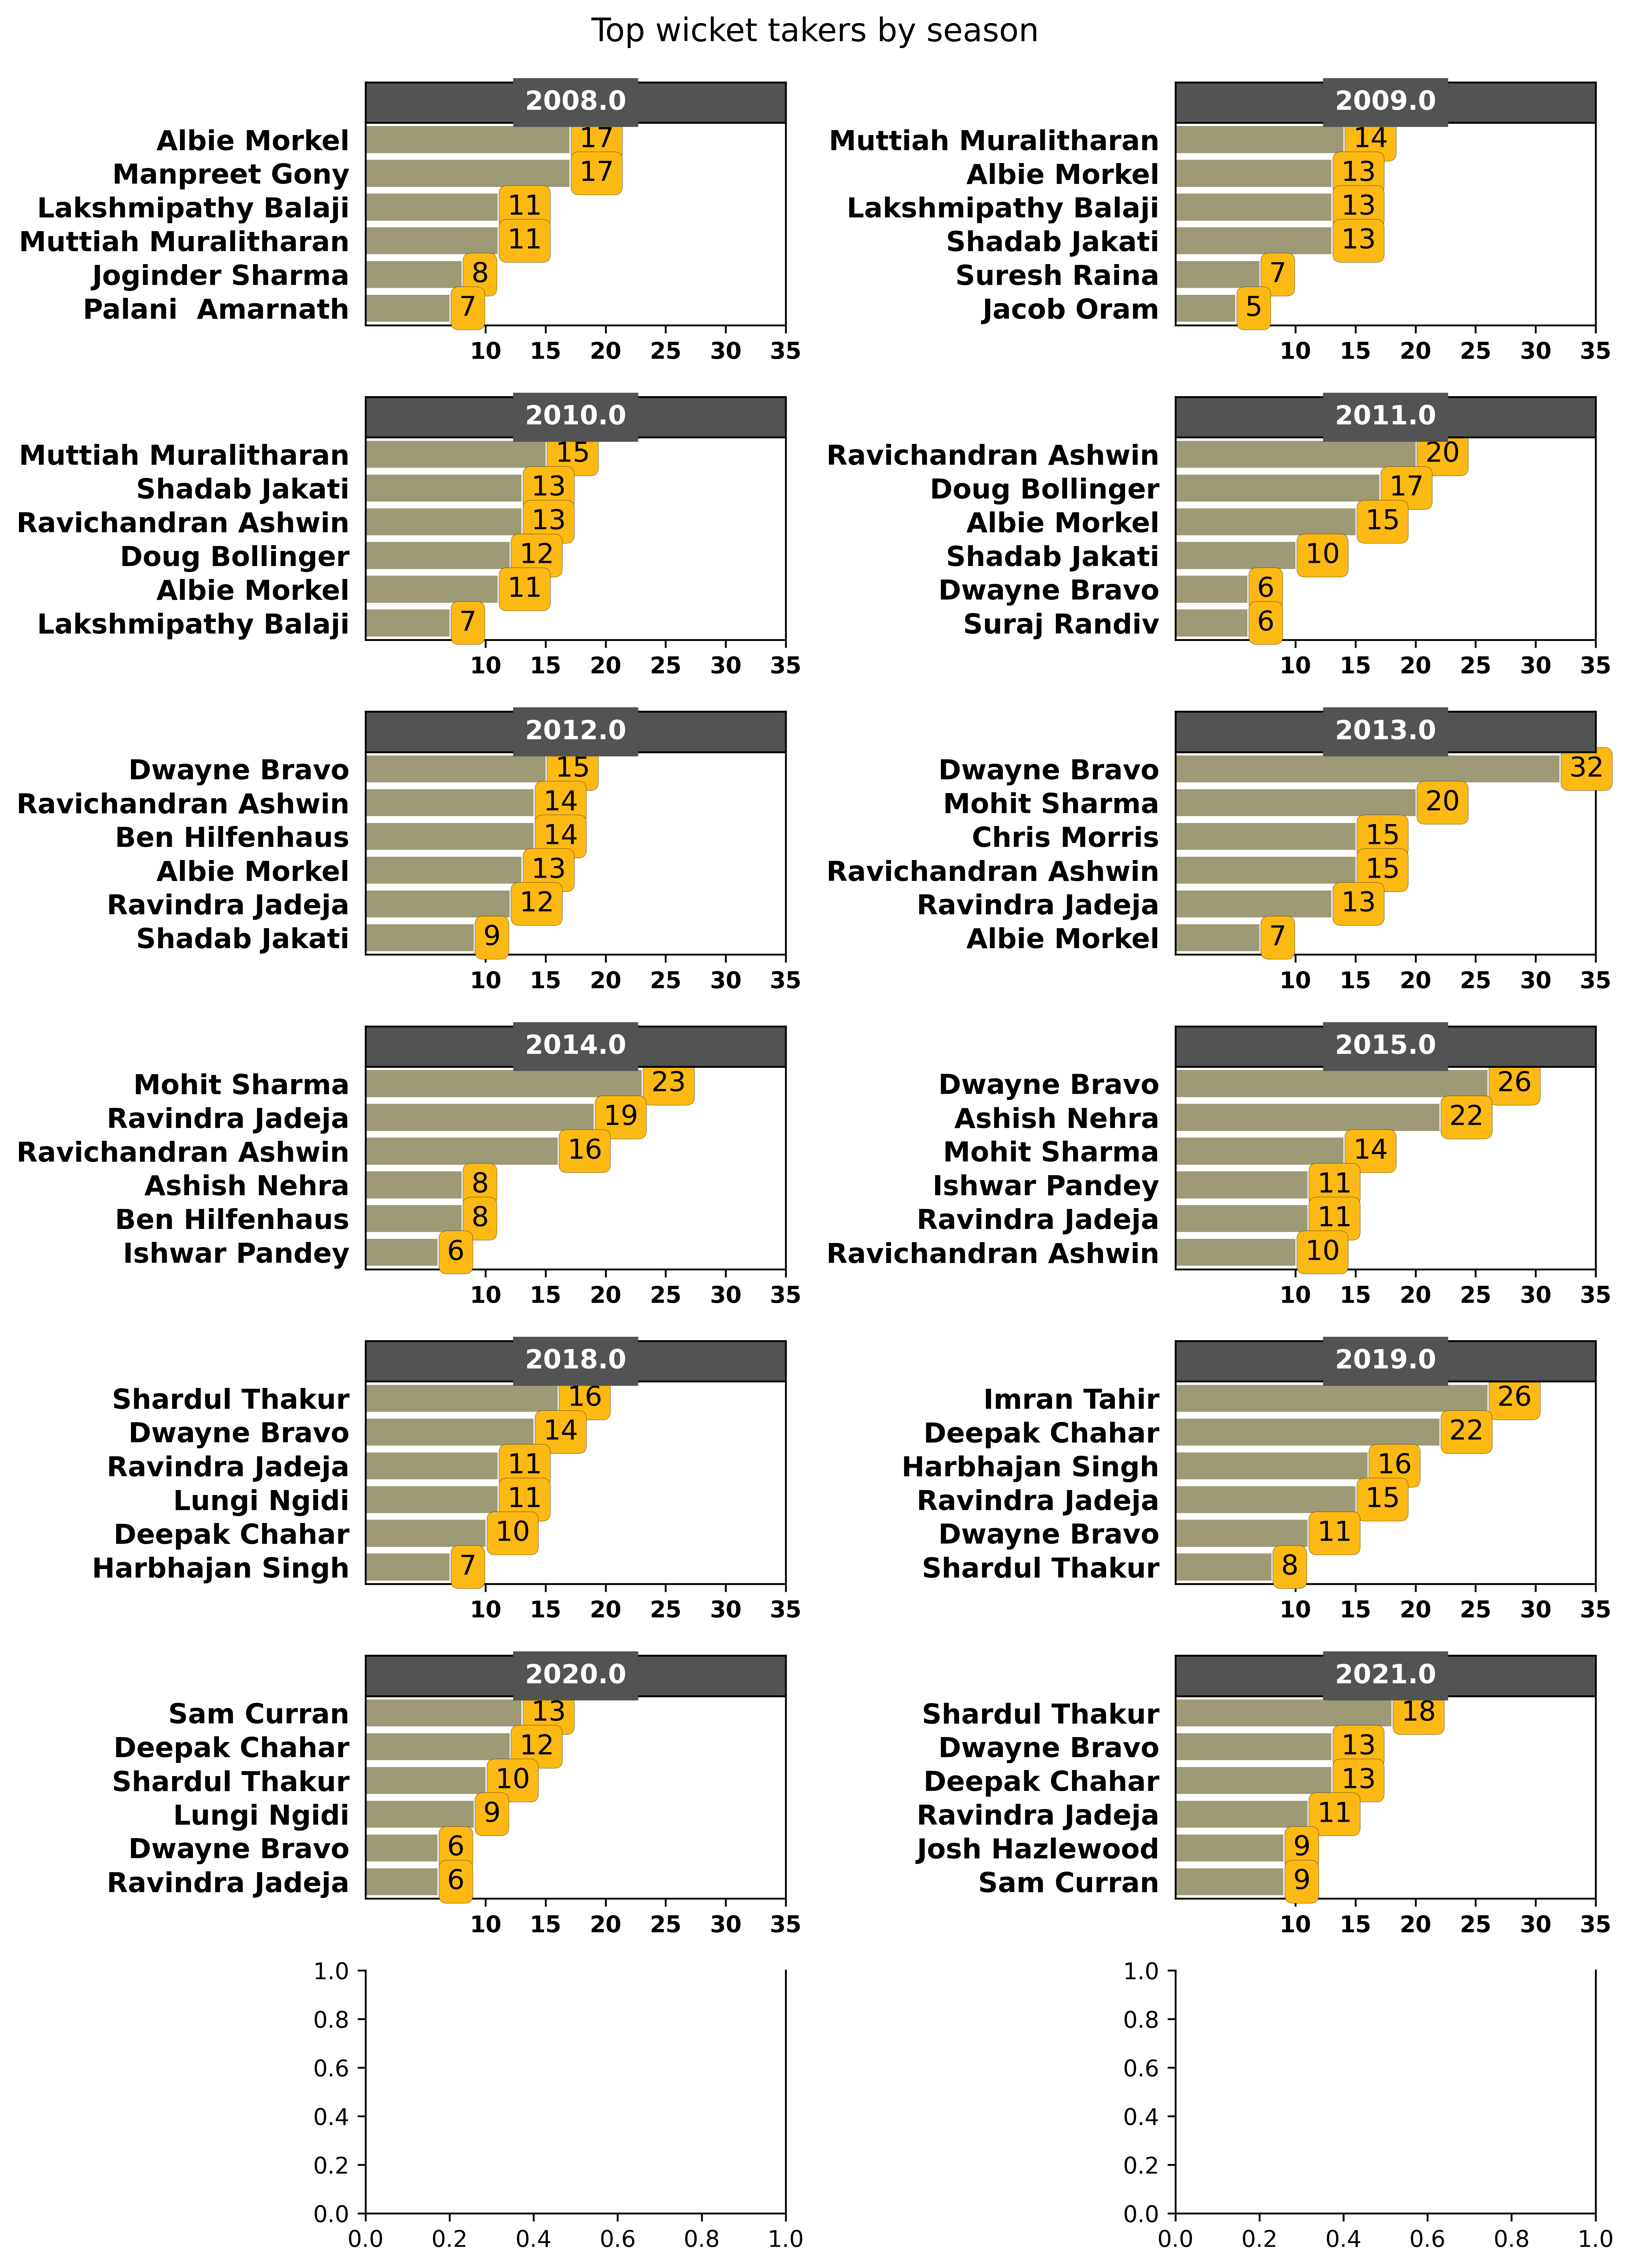

In [34]:
def bowler_per_season(team_code):
    """
    plot bowler per season
    """
    bowler_df = season_bowling_card_df[['season' , 'bowling_team', 'fullName', 'wickets']]
    bowler_df = bowler_df[bowler_df['bowling_team'] == team_code]
    bowler_df = bowler_df.groupby(['season', 'fullName'])['wickets'].sum().reset_index().sort_values('wickets', ascending=False)

    plt.rcParams['figure.dpi'] = 600
    background_color = '#ffffff'
    #fig = plt.figure(figsize=(10, 10), facecolor='#f6f5f5')
    fig = plt.figure(figsize=(10, 14), facecolor='#ffffff')
    #
    gs = fig.add_gridspec(7, 2)
    gs.update(wspace=0.3, hspace=0.4)
    x_ticks_runs = None
    run_no = 0
    for row in range(0, 7):
        for col in range(0, 2):
            locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
            locals()["ax"+str(run_no)].set_facecolor(background_color)
            for s in ["top"]:
                locals()["ax"+str(run_no)].spines[s].set_visible(False)
            run_no += 1
    #locals()["ax"+str(run_no)].axis('off')

    run_no = 0
    for season in sorted(bowler_df['season'].unique()): 
        #locals()["ax"+str(run_no)].set_facecolor(team_colors[opp])    
        locals()["ax"+str(run_no)].set_facecolor('#ffffff')    
        wickets = bowler_df.loc[bowler_df['season'] == season].head(6)
        
        divider = make_axes_locatable(locals()["ax"+str(run_no)])
        cax = divider.append_axes("top", size="20%", pad=0)
        cax.get_xaxis().set_visible(False)
        cax.get_yaxis().set_visible(False)
        cax.set_facecolor('#525453')
        at = AnchoredText(season, loc=10, borderpad=0.5,
                        prop=dict(backgroundcolor='#525453',
                                    size=11.5, color='white', weight='bold'))    
        
        cax.add_artist(at)
        
        sns.barplot(ax=locals()["ax"+str(run_no)], y=wickets['fullName'], x=wickets['wickets'], zorder=2, linewidth=0, orient='h', saturation=1, alpha=1, color='#9e9a75')
        locals()["ax"+str(run_no)].set_ylabel('')
        x_ticks_runs = np.arange(10, 40, 5)
        locals()["ax"+str(run_no)].set_xticks(x_ticks_runs)
        locals()["ax"+str(run_no)].set_xticklabels(x_ticks_runs, fontsize=10, fontweight='bold') 
        locals()["ax"+str(run_no)].tick_params(left=False)    
        locals()["ax"+str(run_no)].set_yticklabels(locals()["ax"+str(run_no)].get_yticklabels(), fontsize=12, fontweight='bold')
        locals()["ax"+str(run_no)].set_xlabel('')
        run_no += 1

    for run_no in range (0,14):
        for p in locals()["ax"+str(run_no)].patches:
            value = int(p.get_width())
            x = p.get_x() + p.get_width() + 0.8
            y = p.get_y() + p.get_height() / 2 
            locals()["ax"+str(run_no)].text(x, y, value, ha='left', va='center', fontsize=12, bbox=dict(facecolor=team_color[team_code],  edgecolor='black', boxstyle='round', linewidth=0.1))

    fig.suptitle('Top wicket takers by season',fontsize = 14)
    gs.tight_layout(fig, rect=[0, 0, 1, 0.99])
    plt.show()
bowler_per_season('CSK')